In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [4]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
import torch
torch.cuda.is_available()


Mounted at /content/gdrive


True

In [5]:
import os
os.listdir( "gdrive/MyDrive/Dataset" )

['Taxi_Trips__2024-__20241019.csv', 'UCMerced_LandUse.zip', 'GTSRB_data.zip']

In [6]:
# Unzip the data set
!unzip "gdrive/MyDrive/Dataset/GTSRB_data.zip"
print( "\n\n" )
os.listdir( )

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  inflating: train/5/00005_00054_00001.png  
  inflating: train/5/00005_00054_00002.png  
  inflating: train/5/00005_00054_00003.png  
  in

['.config',
 'Test.csv',
 'Train',
 'test',
 'Test',
 'gdrive',
 'Meta',
 'meta',
 'Meta.csv',
 'Train.csv',
 'train',
 'sample_data']

In [7]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

In [8]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Cell 2: Dataset Class
class GTSRBDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# Cell 3: Data Loading Function
def create_data_loaders(train_path, use_augmentation=True, batch_size=32):
    if use_augmentation:
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    images, labels = [], []
    for class_id in range(43):
        class_path = os.path.join(train_path, str(class_id))
        for image_path in os.listdir(class_path):
            images.append(os.path.join(class_path, image_path))
            labels.append(class_id)

    X_train, X_val, y_train, y_val = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    train_dataset = GTSRBDataset(X_train, y_train, train_transform)
    val_dataset = GTSRBDataset(X_val, y_val, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

In [11]:
# Cell 4: Model Class
class TrafficSignClassifier(nn.Module):
    def __init__(self, num_classes=43, use_dropout=True):
        super(TrafficSignClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        for param in list(self.resnet.parameters())[:-20]:
            param.requires_grad = False

        num_features = self.resnet.fc.in_features
        if use_dropout:
            self.resnet.fc = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )
        else:
            self.resnet.fc = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, num_classes)
            )

    def forward(self, x):
        return self.resnet(x)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=30, patience=5):
    best_val_acc = 0
    patience_counter = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    # Wrap the epoch loop with tqdm
    for epoch in tqdm(range(num_epochs), desc="Epoch Progress", unit="epoch"):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Update tqdm description
        tqdm.write(f'Epoch: {epoch+1}/{num_epochs}')
        tqdm.write(f'Training Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
        tqdm.write(f'Validation Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            tqdm.write(f'Early stopping triggered after epoch {epoch+1}')
            break

    return history

In [13]:
# Cell 6: Plotting Function
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [16]:
# Cell 7: Run Experiment (Overtraining Example)
# Create model without dropout
model_overfit = TrafficSignClassifier(use_dropout=False).to(device)

# Create data loaders without augmentation
train_loader_basic, val_loader_basic = create_data_loaders('Train',
                                                          use_augmentation=False)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_overfit.parameters(), lr=0.001)

# Train model without early stopping
history_overfit = train_model(
    model_overfit, train_loader_basic, val_loader_basic,
    criterion, optimizer, None, num_epochs=30, patience=float('inf')
)

Epoch Progress:   0%|          | 0/30 [03:28<?, ?epoch/s]

Epoch: 1/30
Training Loss: 0.6076, Acc: 81.48%
Validation Loss: 0.1310, Acc: 95.77%


Epoch Progress:   3%|▎         | 1/30 [06:57<1:41:07, 209.22s/epoch]

Epoch: 2/30
Training Loss: 0.1518, Acc: 95.42%
Validation Loss: 0.0866, Acc: 97.09%


Epoch Progress:   7%|▋         | 2/30 [10:26<1:37:34, 209.07s/epoch]

Epoch: 3/30
Training Loss: 0.0824, Acc: 97.42%
Validation Loss: 0.0602, Acc: 97.96%


Epoch Progress:  13%|█▎        | 4/30 [13:55<1:30:27, 208.74s/epoch]

Epoch: 4/30
Training Loss: 0.0686, Acc: 97.94%
Validation Loss: 0.0950, Acc: 97.08%


Epoch Progress:  13%|█▎        | 4/30 [17:23<1:30:27, 208.74s/epoch]

Epoch: 5/30
Training Loss: 0.0499, Acc: 98.58%
Validation Loss: 0.0547, Acc: 98.38%


Epoch Progress:  20%|██        | 6/30 [20:52<1:23:24, 208.52s/epoch]

Epoch: 6/30
Training Loss: 0.0472, Acc: 98.60%
Validation Loss: 0.0786, Acc: 97.91%


Epoch Progress:  20%|██        | 6/30 [24:20<1:23:24, 208.52s/epoch]

Epoch: 7/30
Training Loss: 0.0380, Acc: 98.95%
Validation Loss: 0.0474, Acc: 98.58%


Epoch Progress:  27%|██▋       | 8/30 [27:47<1:16:16, 208.03s/epoch]

Epoch: 8/30
Training Loss: 0.0345, Acc: 99.09%
Validation Loss: 0.0629, Acc: 98.36%


Epoch Progress:  30%|███       | 9/30 [31:12<1:12:28, 207.08s/epoch]

Epoch: 9/30
Training Loss: 0.0353, Acc: 99.05%
Validation Loss: 0.0560, Acc: 98.55%


Epoch Progress:  33%|███▎      | 10/30 [34:37<1:08:48, 206.41s/epoch]

Epoch: 10/30
Training Loss: 0.0225, Acc: 99.40%
Validation Loss: 0.0612, Acc: 98.48%


Epoch Progress:  33%|███▎      | 10/30 [38:03<1:08:48, 206.41s/epoch]

Epoch: 11/30
Training Loss: 0.0250, Acc: 99.32%
Validation Loss: 0.0481, Acc: 98.60%


Epoch Progress:  40%|████      | 12/30 [41:29<1:01:48, 206.04s/epoch]

Epoch: 12/30
Training Loss: 0.0345, Acc: 99.17%
Validation Loss: 0.0479, Acc: 98.57%


Epoch Progress:  40%|████      | 12/30 [44:53<1:01:48, 206.04s/epoch]

Epoch: 13/30
Training Loss: 0.0303, Acc: 99.25%
Validation Loss: 0.0377, Acc: 99.01%


Epoch Progress:  47%|████▋     | 14/30 [48:17<54:43, 205.21s/epoch]

Epoch: 14/30
Training Loss: 0.0151, Acc: 99.59%
Validation Loss: 0.0447, Acc: 98.93%


Epoch Progress:  47%|████▋     | 14/30 [51:42<54:43, 205.21s/epoch]

Epoch: 15/30
Training Loss: 0.0168, Acc: 99.54%
Validation Loss: 0.0267, Acc: 99.18%


Epoch Progress:  53%|█████▎    | 16/30 [55:07<47:47, 204.84s/epoch]

Epoch: 16/30
Training Loss: 0.0181, Acc: 99.60%
Validation Loss: 0.0347, Acc: 98.97%


Epoch Progress:  57%|█████▋    | 17/30 [58:31<44:20, 204.69s/epoch]

Epoch: 17/30
Training Loss: 0.0208, Acc: 99.55%
Validation Loss: 0.0306, Acc: 99.16%


Epoch Progress:  57%|█████▋    | 17/30 [1:01:56<44:20, 204.69s/epoch]

Epoch: 18/30
Training Loss: 0.0146, Acc: 99.62%
Validation Loss: 0.0257, Acc: 99.23%


Epoch Progress:  63%|██████▎   | 19/30 [1:05:21<37:34, 204.95s/epoch]

Epoch: 19/30
Training Loss: 0.0130, Acc: 99.65%
Validation Loss: 0.0460, Acc: 98.85%


Epoch Progress:  67%|██████▋   | 20/30 [1:08:46<34:08, 204.87s/epoch]

Epoch: 20/30
Training Loss: 0.0169, Acc: 99.54%
Validation Loss: 0.0382, Acc: 99.03%


Epoch Progress:  67%|██████▋   | 20/30 [1:12:11<34:08, 204.87s/epoch]

Epoch: 21/30
Training Loss: 0.0088, Acc: 99.75%
Validation Loss: 0.0300, Acc: 99.27%


Epoch Progress:  73%|███████▎  | 22/30 [1:15:36<27:19, 204.96s/epoch]

Epoch: 22/30
Training Loss: 0.0135, Acc: 99.65%
Validation Loss: 0.0537, Acc: 98.64%


Epoch Progress:  77%|███████▋  | 23/30 [1:19:01<23:54, 204.86s/epoch]

Epoch: 23/30
Training Loss: 0.0219, Acc: 99.48%
Validation Loss: 0.0300, Acc: 99.17%


Epoch Progress:  80%|████████  | 24/30 [1:22:25<20:27, 204.57s/epoch]

Epoch: 24/30
Training Loss: 0.0088, Acc: 99.76%
Validation Loss: 0.0273, Acc: 99.26%


Epoch Progress:  80%|████████  | 24/30 [1:25:49<20:27, 204.57s/epoch]

Epoch: 25/30
Training Loss: 0.0062, Acc: 99.85%
Validation Loss: 0.0279, Acc: 99.36%


Epoch Progress:  87%|████████▋ | 26/30 [1:29:14<13:38, 204.60s/epoch]

Epoch: 26/30
Training Loss: 0.0151, Acc: 99.67%
Validation Loss: 0.0280, Acc: 99.30%


Epoch Progress:  90%|█████████ | 27/30 [1:32:38<10:13, 204.41s/epoch]

Epoch: 27/30
Training Loss: 0.0092, Acc: 99.74%
Validation Loss: 0.0365, Acc: 99.12%


Epoch Progress:  90%|█████████ | 27/30 [1:36:03<10:13, 204.41s/epoch]

Epoch: 28/30
Training Loss: 0.0129, Acc: 99.68%
Validation Loss: 0.0267, Acc: 99.39%


Epoch Progress:  97%|█████████▋| 29/30 [1:39:27<03:24, 204.40s/epoch]

Epoch: 29/30
Training Loss: 0.0077, Acc: 99.81%
Validation Loss: 0.0602, Acc: 98.75%


Epoch Progress: 100%|██████████| 30/30 [1:42:52<00:00, 205.74s/epoch]

Epoch: 30/30
Training Loss: 0.0089, Acc: 99.77%
Validation Loss: 0.0390, Acc: 99.08%


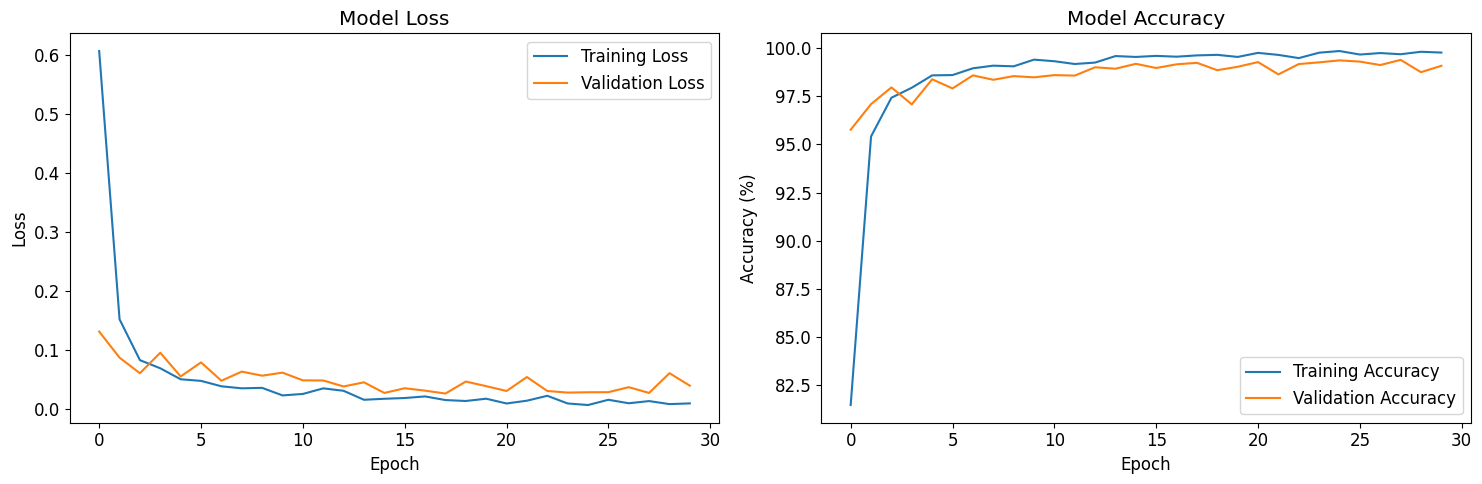

In [18]:
# Plot results
plot_training_history(history_overfit)

# Cell 8: Run Experiment (Preventing Overtraining)
# Create model with dropout
model_proper = TrafficSignClassifier(use_dropout=True).to(device)

# Create data loaders with augmentation
train_loader, val_loader = create_data_loaders('Train', use_augmentation=True)

In [19]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_proper.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.001, epochs=30,
                      steps_per_epoch=len(train_loader))

In [ ]:
# Train model with all prevention techniques
history_proper = train_model(
    model_proper, train_loader, val_loader,
    criterion, optimizer, scheduler, num_epochs=30, patience=5
)

Epoch Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

In [ ]:
# Plot results
plot_training_history(history_proper)